# IMPORT LIBRARIES AND FILES

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

- We first need to merge these datasets for CO2, CH4 and N2O [Greenhouse gases (GHGs)] into 1 big dataset

In [29]:
# Read the data
CO2_emission = pd.read_csv('CO2_inc_landuse.csv')
CH4_emission = pd.read_csv('methane.csv')
N2O_emission =  pd.read_csv('nitrous_oxide.csv')
temperature = pd.read_csv('warming_impact.csv')
mitigation = pd.read_csv('CO2_mitigation_2C.csv')
sectors = pd.read_csv('ghg-emissions-by-sector.csv')

In [30]:
# Check the information
CO2_emission.info()
CH4_emission.info()
N2O_emission.info()
temperature.info()
mitigation.info()
sectors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24212 entries, 0 to 24211
Data columns (total 4 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Entity                                          24212 non-null  object 
 1   Code                                            21466 non-null  object 
 2   Year                                            24212 non-null  int64  
 3   Annual CO₂ emissions including land-use change  24212 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 756.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37496 entries, 0 to 37495
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Entity                                       37496 non-null  object 
 1   Code                           

- Keep only countries, not regions [NaN 'code'] and filter for 100 years [1921-2021]

In [31]:
# Drop NaN values and filter year range for CO2_emission
CO2_emission = CO2_emission.dropna(subset=['Code'])
CO2_emission = CO2_emission[CO2_emission['Year'] >= 1921]

# Drop NaN values and filter year range for CH4_emission
CH4_emission = CH4_emission.dropna(subset=['Code'])
CH4_emission = CH4_emission[CH4_emission['Year'] >= 1921]

# Drop NaN values and filter year range for N2O_emission
N2O_emission = N2O_emission.dropna(subset=['Code'])
N2O_emission = N2O_emission[N2O_emission['Year'] >= 1921]

# Drop NaN values and filter year range for temperature
temperature = temperature.dropna(subset=['Code'])
temperature = temperature[temperature['Year'] >= 1921]

In [32]:
# Merge the data tables using 'Code' and 'Year' with suffixes
merged_data = CO2_emission.merge(CH4_emission, on=['Code', 'Year'], how='inner', suffixes=('_CO2', '_CH4'))
merged_data = merged_data.merge(N2O_emission, on=['Code', 'Year'], how='inner', suffixes=('_CH4', '_N2O'))
merged_data = merged_data.merge(temperature, on=['Code', 'Year'], how='inner', suffixes=('_N2O', '_temperature'))

# Drop duplicate columns
merged_data = merged_data.drop(['Entity_CH4', 'Entity_N2O'], axis=1)

# Rename the columns
merged_data = merged_data.rename(columns={'Entity_CO2': 'Country_name', 'Code': 'Country_code',
                                          'Annual CO₂ emissions including land-use change': 'CO2_emission',
                                          'Annual methane emissions in CO2 equivalents' : 'CH4_emission',
                                          'Annual nitrous oxide emissions in CO2 equivalents' :'N2O_emission',
                                          'Change in global mean surface temperature caused by greenhouse gas emissions' : 'Temperature_change'})

# Reorder the columns
merged_data = merged_data[['Country_name', 'Country_code', 'Year', 'CO2_emission', 'CH4_emission', 'N2O_emission', 'Temperature_change']]

# Add a column for total GHG emission
merged_data['Total_emission'] = merged_data['CO2_emission'] + merged_data['CH4_emission'] + merged_data['N2O_emission']

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15767 entries, 0 to 15766
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country_name        15767 non-null  object 
 1   Country_code        15767 non-null  object 
 2   Year                15767 non-null  int64  
 3   CO2_emission        15767 non-null  float64
 4   CH4_emission        15767 non-null  float64
 5   N2O_emission        15767 non-null  float64
 6   Temperature_change  15767 non-null  float64
 7   Total_emission      15767 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.1+ MB


- Let's check out mitigation dataset

In [33]:
# Check for NaNs and drop column 'Code'
mitigation.isna().sum()
mitigation.drop(columns='Code', inplace=True)
mitigation.head()

,Entity,Year,CO2 mitigation curves to meet a 2C target
0,Historical,1850,2717041000
1,Historical,1851,2733435000
2,Historical,1852,2760245000
3,Historical,1853,2788877000
4,Historical,1854,2836878000


- Now it's the dataset for emission in different sectors

In [34]:
# Filter out only countries with code, drop the code columm and rename
sectors = sectors.dropna(subset=['Code'])
sectors.drop(columns='Code', inplace=True)
sectors.rename(columns={'Entity': 'Country_name'}, inplace=True)

# Calculate the percentage of null values for each column
null_percentages = (sectors.isnull().sum() / len(sectors)) * 100

# Display the null percentages
print(null_percentages)

Country_name                      0.000000
Year                              0.000000
Agriculture                       0.567010
Land-use change and forestry      0.051546
Waste                             1.030928
Industry                          0.000000
Manufacturing and construction    2.663230
Transport                         2.663230
Electricity and heat              2.663230
Buildings                         2.663230
Fugitive emissions                1.030928
Other fuel combustion             2.663230
Aviation and shipping             2.663230
dtype: float64


In [35]:
# We can drop the missing values since their percentages are very small
sectors.dropna(inplace=True)
sectors.info()
sectors.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5602 entries, 0 to 6149
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Country_name                    5602 non-null   object 
 1   Year                            5602 non-null   int64  
 2   Agriculture                     5602 non-null   float64
 3   Land-use change and forestry    5602 non-null   float64
 4   Waste                           5602 non-null   float64
 5   Industry                        5602 non-null   float64
 6   Manufacturing and construction  5602 non-null   float64
 7   Transport                       5602 non-null   float64
 8   Electricity and heat            5602 non-null   float64
 9   Buildings                       5602 non-null   float64
 10  Fugitive emissions              5602 non-null   float64
 11  Other fuel combustion           5602 non-null   float64
 12  Aviation and shipping           56

,Country_name,Year,Agriculture,Land-use change and forestry,Waste,Industry,Manufacturing and construction,Transport,Electricity and heat,Buildings,Fugitive emissions,Other fuel combustion,Aviation and shipping
0,Afghanistan,1990,8.070000e+06,-2.390000e+06,1.230000e+06,50000.000745,409999.996424,1.670000e+06,170000.001788,79999.998212,280000.001192,0.0,19999.999553
1,Afghanistan,1991,8.400000e+06,-2.390000e+06,1.320000e+06,59999.998659,400000.005960,1.550000e+06,170000.001788,70000.000298,239999.994636,0.0,19999.999553
2,Afghanistan,1992,8.410000e+06,-2.390000e+06,1.400000e+06,59999.998659,370000.004768,7.700000e+05,159999.996424,29999.999329,200000.002980,0.0,19999.999553
3,Afghanistan,1993,8.490000e+06,-2.390000e+06,1.490000e+06,59999.998659,360000.014305,7.400000e+05,159999.996424,29999.999329,159999.996424,0.0,19999.999553
4,Afghanistan,1994,8.520000e+06,-2.390000e+06,1.580000e+06,59999.998659,340000.003576,7.100000e+05,159999.996424,19999.999553,119999.997318,0.0,19999.999553


# EXPLORATORY DATA ANALYSIS

## 1. Greenhouse gas emissions

- Greenhouse gas emissions include carbon dioxide, methane and nitrous oxide from all sources, including agriculture and land use change. They are measured in carbon dioxide-equivalents over a 100-year timescale.

In [36]:
# Filter out 'World' values
world_data = merged_data[merged_data['Country_name'].isin(['World'])]
merged_data = merged_data[~merged_data['Country_name'].isin(['World'])]

# Look at the CO2 and greenhouse gases emissions over the years
merged_data.head()

,Country_name,Country_code,Year,CO2_emission,CH4_emission,N2O_emission,Temperature_change,Total_emission
0,Afghanistan,AFG,1949,8038816.0,7900675.5,2164515.8,0.000490,18104007.3
1,Afghanistan,AFG,1950,8584752.0,8101785.0,2233092.2,0.000500,18919629.2
2,Afghanistan,AFG,1951,9141680.0,8234519.0,2294349.2,0.000511,19670548.2
3,Afghanistan,AFG,1952,9947760.0,8373837.0,2367657.5,0.000522,20689254.5
4,Afghanistan,AFG,1953,10915056.0,8529120.0,2449182.2,0.000533,21893358.2


In [37]:
# Look at top 10 countries with the most CO2, CH4, N2On and total emissions over the years
CO2_top = merged_data.groupby('Country_name')['CO2_emission'].sum().reset_index().sort_values(by='CO2_emission', ascending=False).head(10)
CO2_top_countries = CO2_top['Country_name'].unique()
print(list(CO2_top_countries))

CH4_top = merged_data.groupby('Country_name')['CH4_emission'].sum().reset_index().sort_values(by='CH4_emission', ascending=False).head(10)
CH4_top_countries = CH4_top['Country_name'].unique()
print(list(CH4_top_countries))

N2O_top = merged_data.groupby('Country_name')['N2O_emission'].sum().reset_index().sort_values(by='N2O_emission', ascending=False).head(10)
N2O_top_countries = N2O_top['Country_name'].unique()
print(list(N2O_top_countries))

total_top = merged_data.groupby('Country_name')['Total_emission'].sum().reset_index().sort_values(by='Total_emission', ascending=False).head(10)
total_top_countries = total_top['Country_name'].unique()
print(list(total_top_countries))

['United States', 'China', 'Russia', 'Brazil', 'India', 'Germany', 'Indonesia', 'Japan', 'Canada', 'United Kingdom']
['China', 'United States', 'India', 'Russia', 'Brazil', 'Indonesia', 'Nigeria', 'United Kingdom', 'Germany', 'Australia']
['United States', 'China', 'India', 'Brazil', 'Russia', 'Australia', 'Indonesia', 'Germany', 'France', 'Mexico']
['United States', 'China', 'Russia', 'India', 'Brazil', 'Indonesia', 'Germany', 'Japan', 'Canada', 'United Kingdom']


In [ ]:
# Filter out the top 10 countries data
top_CO2_emission = merged_data[merged_data['Country_name'].isin(CO2_top_countries)]
top_CH4_emission = merged_data[merged_data['Country_name'].isin(CH4_top_countries)]
top_N2O_emission = merged_data[merged_data['Country_name'].isin(N2O_top_countries)]
top_total_emission = merged_data[merged_data['Country_name'].isin(total_top_countries)]

# Convert emissions to billion tonnes
top_CO2_emission['CO2_emission'] = top_CO2_emission['CO2_emission'] / 1e9
top_CH4_emission['CH4_emission'] = top_CH4_emission['CH4_emission'] / 1e9
top_N2O_emission['N2O_emission'] = top_N2O_emission['N2O_emission'] / 1e9
top_total_emission['Total_emission'] = top_total_emission['Total_emission'] / 1e9

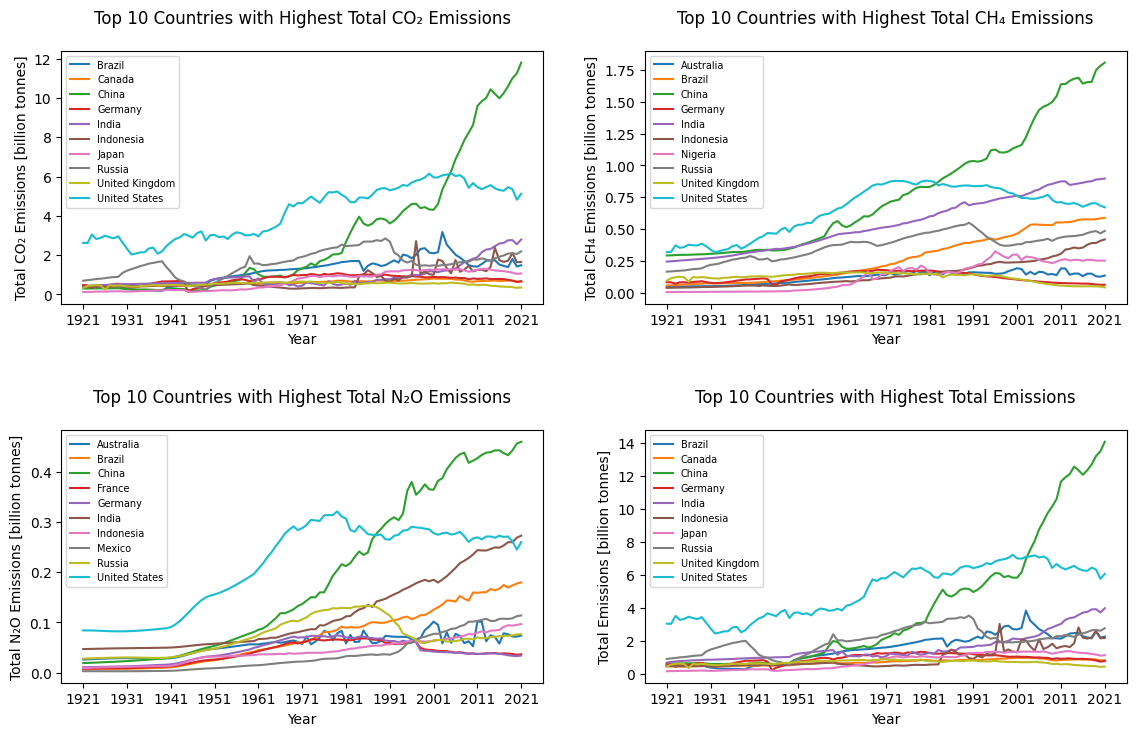

In [39]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot CO2 emissions
sns.lineplot(ax=axes[0, 0], data=top_CO2_emission, x='Year', y='CO2_emission', hue='Country_name')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Total CO₂ Emissions [billion tonnes]')
axes[0, 0].set_title('Top 10 Countries with Highest Total CO₂ Emissions', pad=20)
axes[0, 0].set_xticks(range(1921, 2022, 10))
axes[0, 0].legend(fontsize=7)

# Plot CH4 emissions
sns.lineplot(ax=axes[0, 1], data=top_CH4_emission, x='Year', y='CH4_emission', hue='Country_name')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Total CH₄ Emissions [billion tonnes]')
axes[0, 1].set_title('Top 10 Countries with Highest Total CH₄ Emissions', pad=20)
axes[0, 1].set_xticks(range(1921, 2022, 10))
axes[0, 1].legend(fontsize=7)

# Plot N2O emissions
sns.lineplot(ax=axes[1, 0], data=top_N2O_emission, x='Year', y='N2O_emission', hue='Country_name')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Total N₂O Emissions [billion tonnes]')
axes[1, 0].set_title('Top 10 Countries with Highest Total N₂O Emissions', pad=20)
axes[1, 0].set_xticks(range(1921, 2022, 10))
axes[1, 0].legend(fontsize=7)

# Plot total emissions
sns.lineplot(ax=axes[1, 1], data=top_total_emission, x='Year', y='Total_emission', hue='Country_name')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Emissions [billion tonnes]')
axes[1, 1].set_title('Top 10 Countries with Highest Total Emissions', pad=20)
axes[1, 1].set_xticks(range(1921, 2022, 10))
axes[1, 1].legend(fontsize=7)

plt.tight_layout(pad=3.0)  # Adjust the padding between subplots and titles
plt.show()


- It looks like China has emitted the most GHGs for the past 20 years and the amounts are also significantly higher than other countries.
- Carbon dioxide is the major GHG, has the highest emission.
- Let's see how the total emissions of the world will change in around 100 years. We can fit a polynomial line using our current data and project it to 2100.

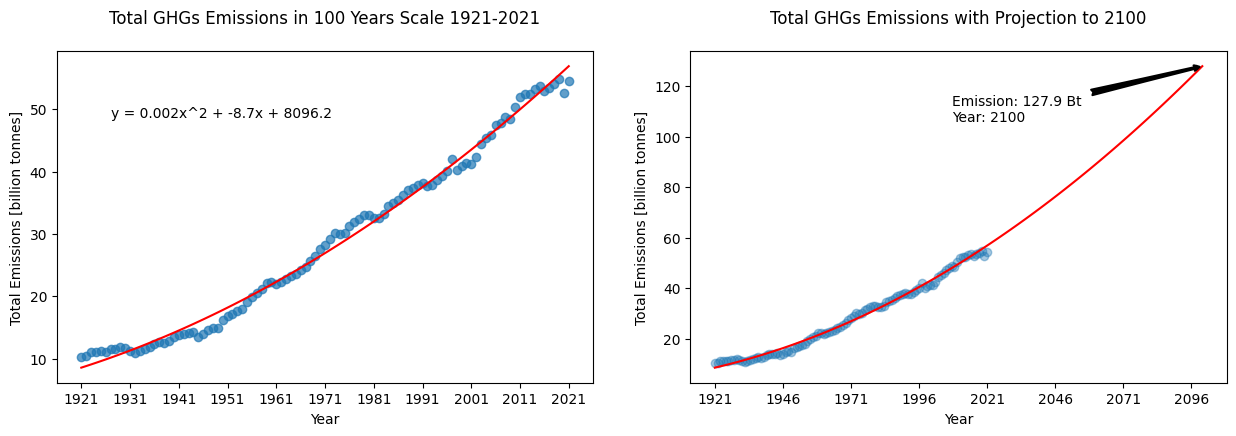

In [40]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Scatter plot
axes[0].scatter(world_data['Year'], world_data['Total_emission'] / 1e9, alpha=0.7)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Emissions [billion tonnes]')
axes[0].set_title('Total GHGs Emissions in 100 Years Scale 1921-2021', pad=20)
axes[0].set_xticks(range(1921, 2022, 10))

# Fit a polynomial regression line
coefficients = np.polyfit(world_data['Year'], world_data['Total_emission'] / 1e9, 2)
p = np.poly1d(coefficients)

# Generate x values for the line plot
x = np.linspace(min(world_data['Year']), max(world_data['Year']), 100)

# Calculate y values using the polynomial function
y = p(x)

# Plot the polynomial regression line
axes[0].plot(x, y, color='red', label='Polynomial Line')

# Polynomial equation
equation = f"y = {coefficients[0]:.3f}x^2 + {coefficients[1]:.1f}x + {coefficients[2]:.1f}"
axes[0].text(0.1, 0.8, equation, transform=axes[0].transAxes, fontsize=10)

# Scatter plot and polynomial regression line with projection to 2071
axes[1].scatter(world_data['Year'], world_data['Total_emission'] / 1e9, alpha=0.4)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Emissions [billion tonnes]')
axes[1].set_title('Total GHGs Emissions with Projection to 2100', pad=20)
axes[1].set_xticks(range(1921, 2102, 25))

# Generate x values for the projected line plot
x_proj = np.linspace(min(world_data['Year']), 2100, 100)

# Calculate y values for the projected line using the polynomial function
y_proj = p(x_proj)

# Plot the projected line
axes[1].plot(x_proj, y_proj, color='red', label='Polynomial Line')

# Find the maximum emission value and its corresponding year
max_emission = max(y_proj)
max_year = x_proj[np.argmax(y_proj)]

# Annotate the maximum value on the plot
axes[1].annotate(f"Emission: {max_emission:.1f} Bt \nYear: {max_year:.0f}",
                 xy=(max_year, max_emission), xycoords='data',
                 xytext=(-180,-40), textcoords='offset points',
                 arrowprops=dict(arrowstyle="fancy", linewidth=1.5, color="black"))

plt.tight_layout(pad=3.0)
plt.show()

- If we keep up this pace with no policy to cut down the emission, in about 100 years, the world will reach 127.9 billion tonnes of GHGs emission.

- Let's see for the past 10 year 2011-2021, which countries have the most emissions?

In [41]:
# Filter out years
top_total_emission_filtered = top_total_emission[top_total_emission['Year'] >= 2011][['Country_name', 'Year', 'Total_emission']]

# Group by country
top_10 = top_total_emission_filtered.groupby('Country_name')['Total_emission'].sum().reset_index().sort_values(by='Total_emission', ascending=False).head(10)

# Calculate percentage difference for each country
for country in top_10['Country_name'].unique():
    emission_2011 = top_total_emission_filtered.loc[(top_total_emission_filtered['Year'] == 2011) &
                                                    (top_total_emission_filtered['Country_name'] == country), 'Total_emission'].values[0]
    emission_2021 = top_total_emission_filtered.loc[(top_total_emission_filtered['Year'] == 2021) &
                                                    (top_total_emission_filtered['Country_name'] == country), 'Total_emission'].values[0]
    percentage_difference = (emission_2021 - emission_2011) * 100 / emission_2011
    top_10.loc[top_10['Country_name'] == country, 'emission_2011'] = emission_2011
    top_10.loc[top_10['Country_name'] == country, 'emission_2021'] = emission_2021
    top_10.loc[top_10['Country_name'] == country, 'percentage_difference'] = percentage_difference

top_10 = top_10.drop(columns=['Total_emission'])
# Display the result
print(f'Within 10 years 2011-2021, top 10 countries with the most greenhouse gas emissions are: \n\n{top_10} \n')

Within 10 years 2011-2021, top 10 countries with the most greenhouse gas emissions are: 

     Country_name  emission_2011  emission_2021  percentage_difference
2           China      11.652182      14.065861              20.714389
9   United States       6.445714       6.051976              -6.108519
4           India       3.015057       3.964901              31.503356
7          Russia       2.269921       2.755419              21.388346
0          Brazil       2.124313       2.250341               5.932635
5       Indonesia       1.630443       2.166272              32.863976
6           Japan       1.312184       1.117825             -14.811898
3         Germany       0.903157       0.767391             -15.032399
1          Canada       0.827133       0.814519              -1.525081
8  United Kingdom       0.554940       0.425536             -23.318515 



- Let's dive deep into China, United States and India - current top emitters
- In 2015, at Paris Agreement, these countries made pledges to reduce CO₂ emission. One of the pledges is to reduce certain amount by 2030.

In [42]:
countries = ['China', 'United States', 'India']
pledged_reduce = [0.6, 0.28, 0.33]  # Check Paris Agreement reference

data = []  # Initialize an empty list to store the data

for i, c in enumerate(countries):
    emission_2005 = top_total_emission.loc[(top_total_emission['Country_name'] == c) &
                                           (top_total_emission['Year'] == 2005), 'Total_emission'].values[0]
    emission_2021 = top_total_emission.loc[(top_total_emission['Country_name'] == c) &
                                           (top_total_emission['Year'] == 2021), 'Total_emission'].values[0]

    # Create a dictionary for each country's data
    country_data = {'Country': c,
                    'Emission_2005': emission_2005,
                    'Emission_2021': emission_2021,
                    'Pledged_reduce': pledged_reduce[i]}

    data.append(country_data)  # Append the country's data to the list

# Create the DataFrame
pledged_df = pd.DataFrame(data)

# Calculate projected pledged 2030 emissions
pledged_df['Goal_2030'] = pledged_df['Emission_2005'] * (1 - pledged_df['Pledged_reduce'])
pledged_df['Need_to_reduce_%'] = (pledged_df['Emission_2021'] - pledged_df['Goal_2030']) * 100 / pledged_df['Emission_2021']
pledged_df

,Country,Emission_2005,Emission_2021,Pledged_reduce,Goal_2030,Need_to_reduce_%
0,China,8.050933,14.065861,0.60,3.220373,77.105041
1,United States,7.176074,6.051976,0.28,5.166773,14.626679
2,India,2.249695,3.964901,0.33,1.507296,61.984017


## 2. Contribution to global mean Earth surface temperature rise

- The global mean surface temperature change as a result of a country or region's cumulative emissions of three gases – carbon dioxide, methane,
and nitrous oxide.

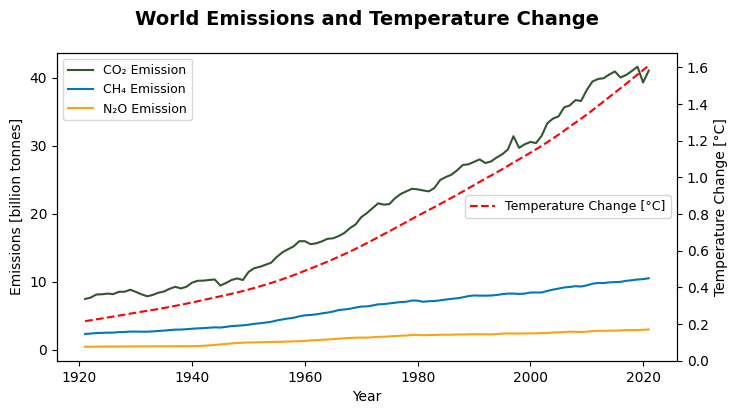

In [57]:
# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plotting the emissions on the left y-axis
sns.lineplot(data=world_data, x='Year', y=world_data['CO2_emission'].div(1e9),
             label='CO₂ Emission', color='#31572C', ax=ax1)
sns.lineplot(data=world_data, x='Year', y=world_data['CH4_emission'].div(1e9),
             label='CH₄ Emission', color='#0077B6', ax=ax1)
sns.lineplot(data=world_data, x='Year', y=world_data['N2O_emission'].div(1e9),
             label='N₂O Emission', color='#FCA311', ax=ax1)

# Setting the y-axis label for emissions
ax1.set_ylabel('Emissions [billion tonnes]', fontsize=10)

# Create a dual axis for temperature change
ax2 = ax1.twinx()

# Plotting the temperature change on the right y-axis
sns.lineplot(data=world_data, x='Year', y='Temperature_change',
             label='Temperature Change [°C]', color='r', linestyle='dashed', ax=ax2)

# Setting the y-axis label for temperature change
ax2.set_ylabel('Temperature Change [°C]', fontsize=10)
ax2.set_yticks(np.arange(0, 1.8, 0.2))

# Setting the title and x-axis label
plt.title('World Emissions and Temperature Change', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Year')

ax1.legend(loc='upper left', fontsize=9)
ax2.legend(loc='center right', fontsize=9)
plt.show()

- Surface temperature change follows the CO₂ emission the best since CO₂ accounts for

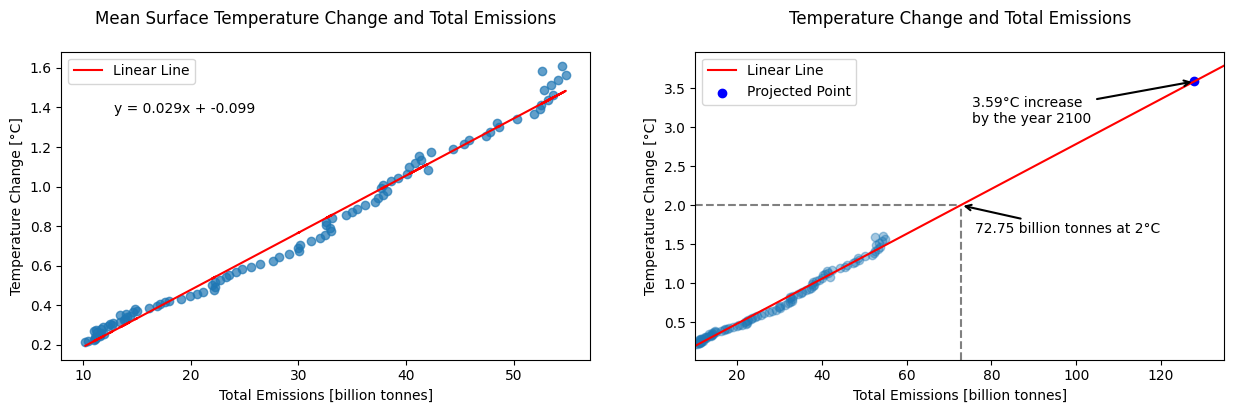

In [44]:
# Fit a linear regression line
slope, intercept = np.polyfit(world_data['Total_emission'] / 1e9, world_data['Temperature_change'], 1)

# Generate x values for the line plot (extended range for the second subplot only)
x1 = world_data['Total_emission'] / 1e9
x2 = np.linspace(min(world_data['Total_emission'] / 1e9), max(world_data['Total_emission'] / 1e9) + 80, 100)

# Calculate y values using the linear function
y = slope * x1 + intercept

# Equation of the linear line
equation = f"y = {slope:.3f}x + {intercept:.3f}"

# Calculate temperature change for given emission of year 2100
emission = 127.9
temperature_change = emission * slope + intercept

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Scatter plot with linear regression line (first subplot)
axes[0].scatter(world_data['Total_emission'] / 1e9, world_data['Temperature_change'], alpha=0.7)
axes[0].plot(x1, y, color='red', label='Linear Line')
axes[0].set_xlabel('Total Emissions [billion tonnes]')
axes[0].set_ylabel('Temperature Change [°C]')
axes[0].set_title('Mean Surface Temperature Change and Total Emissions', pad=20)
axes[0].legend()
axes[0].text(0.1, 0.8, equation, transform=axes[0].transAxes, fontsize=10)

# Plot the projected line and point (second subplot)
axes[1].scatter(world_data['Total_emission'] / 1e9, world_data['Temperature_change'], alpha=0.4)
axes[1].plot(x2, slope * x2 + intercept, color='red', label='Linear Line')
axes[1].scatter(emission, temperature_change, color='blue', label='Projected Point')
axes[1].set_xlim([min(world_data['Total_emission'] / 1e9), max(world_data['Total_emission'] / 1e9) + 80])
axes[1].set_xlabel('Total Emissions [billion tonnes]')
axes[1].set_ylabel('Temperature Change [°C]')
axes[1].set_title('Temperature Change and Total Emissions', pad=20)
axes[1].legend()
axes[1].annotate(f"{temperature_change:.2f}°C increase \nby the year 2100",
                 xy=(emission, temperature_change), fontsize=10,
                 xytext=(-160,-30), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", linewidth=1.5, color="black"))

# Calculate the emission value for 2C change
x_2degree = (2 - intercept) / slope
# Add dashed lines for the 2 degree Celsius point
axes[1].axvline(x_2degree, color='gray', linestyle='--', ymin=0, ymax=0.5)
axes[1].axhline(2, color='gray', linestyle='--', xmin=0, xmax=0.5)

# Annotate the 2 degree Celsius point
axes[1].annotate(f"{x_2degree:.2f} billion tonnes at 2°C",
                 xy=(x_2degree, 2), xycoords='data',
                 xytext=(10, -20), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", linewidth=1.5, color="black"))

plt.show()


In [45]:
# Find the "Year" value when total emissions are 72.75 billion tonnes using previous polynomial line
x_year_2degree = np.interp(72.75, y_proj, x_proj)

# Print the "Year" value
print(f'Year that we will reach total emissions of 72.75 billion tonnes: {x_year_2degree:.0f}')

Year that we will reach total emissions of 72.75 billion tonnes: 2042


## 3. Carbon Dioxide Mitigation

- In order to reach the target of global temperature rise below 2°C by 2100, every country needs to reduce their emissions, especially on CO₂ emissions.
- Using the mitigation data, we can plot the start year curves of CO₂ reductions needed.

In [ ]:
# Filter the data for years >= 1980 to better show the curves
mitigation_filtered = mitigation[mitigation['Year'] >= 1980]
mitigation_filtered['CO2 mitigation curves to meet a 2C target'] = mitigation_filtered['CO2 mitigation curves to meet a 2C target'] / 1e9

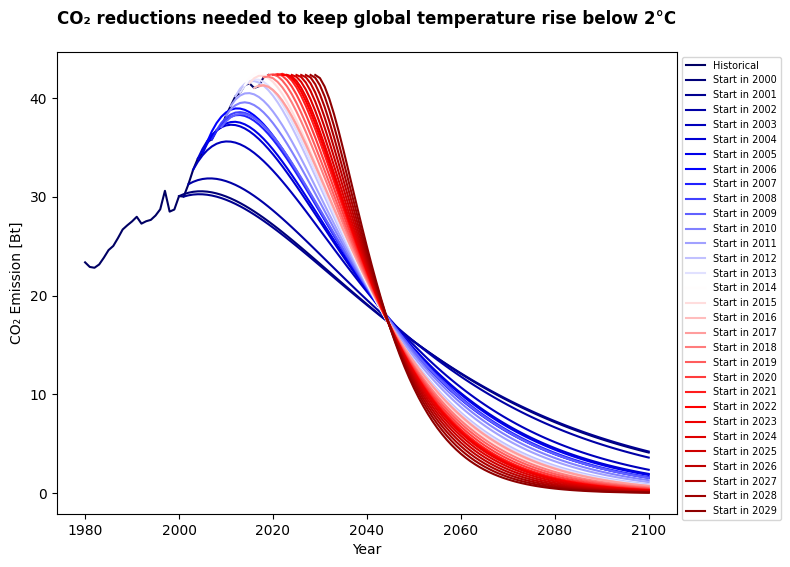

In [61]:
# Overall plot for all start years
plt.figure(figsize=(8, 6))

# Plotting the lines for each entity with custom colors and line styles
sns.lineplot(data=mitigation_filtered, x='Year', y='CO2 mitigation curves to meet a 2C target',
             hue='Entity', palette='seismic')

# Setting the title and labels
plt.title('CO₂ reductions needed to keep global temperature rise below 2°C', fontweight='bold', pad=20)
plt.xlabel('Year')
plt.ylabel('CO₂ Emission [Bt]')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=7)
plt.show()


- We can look at each curve individually

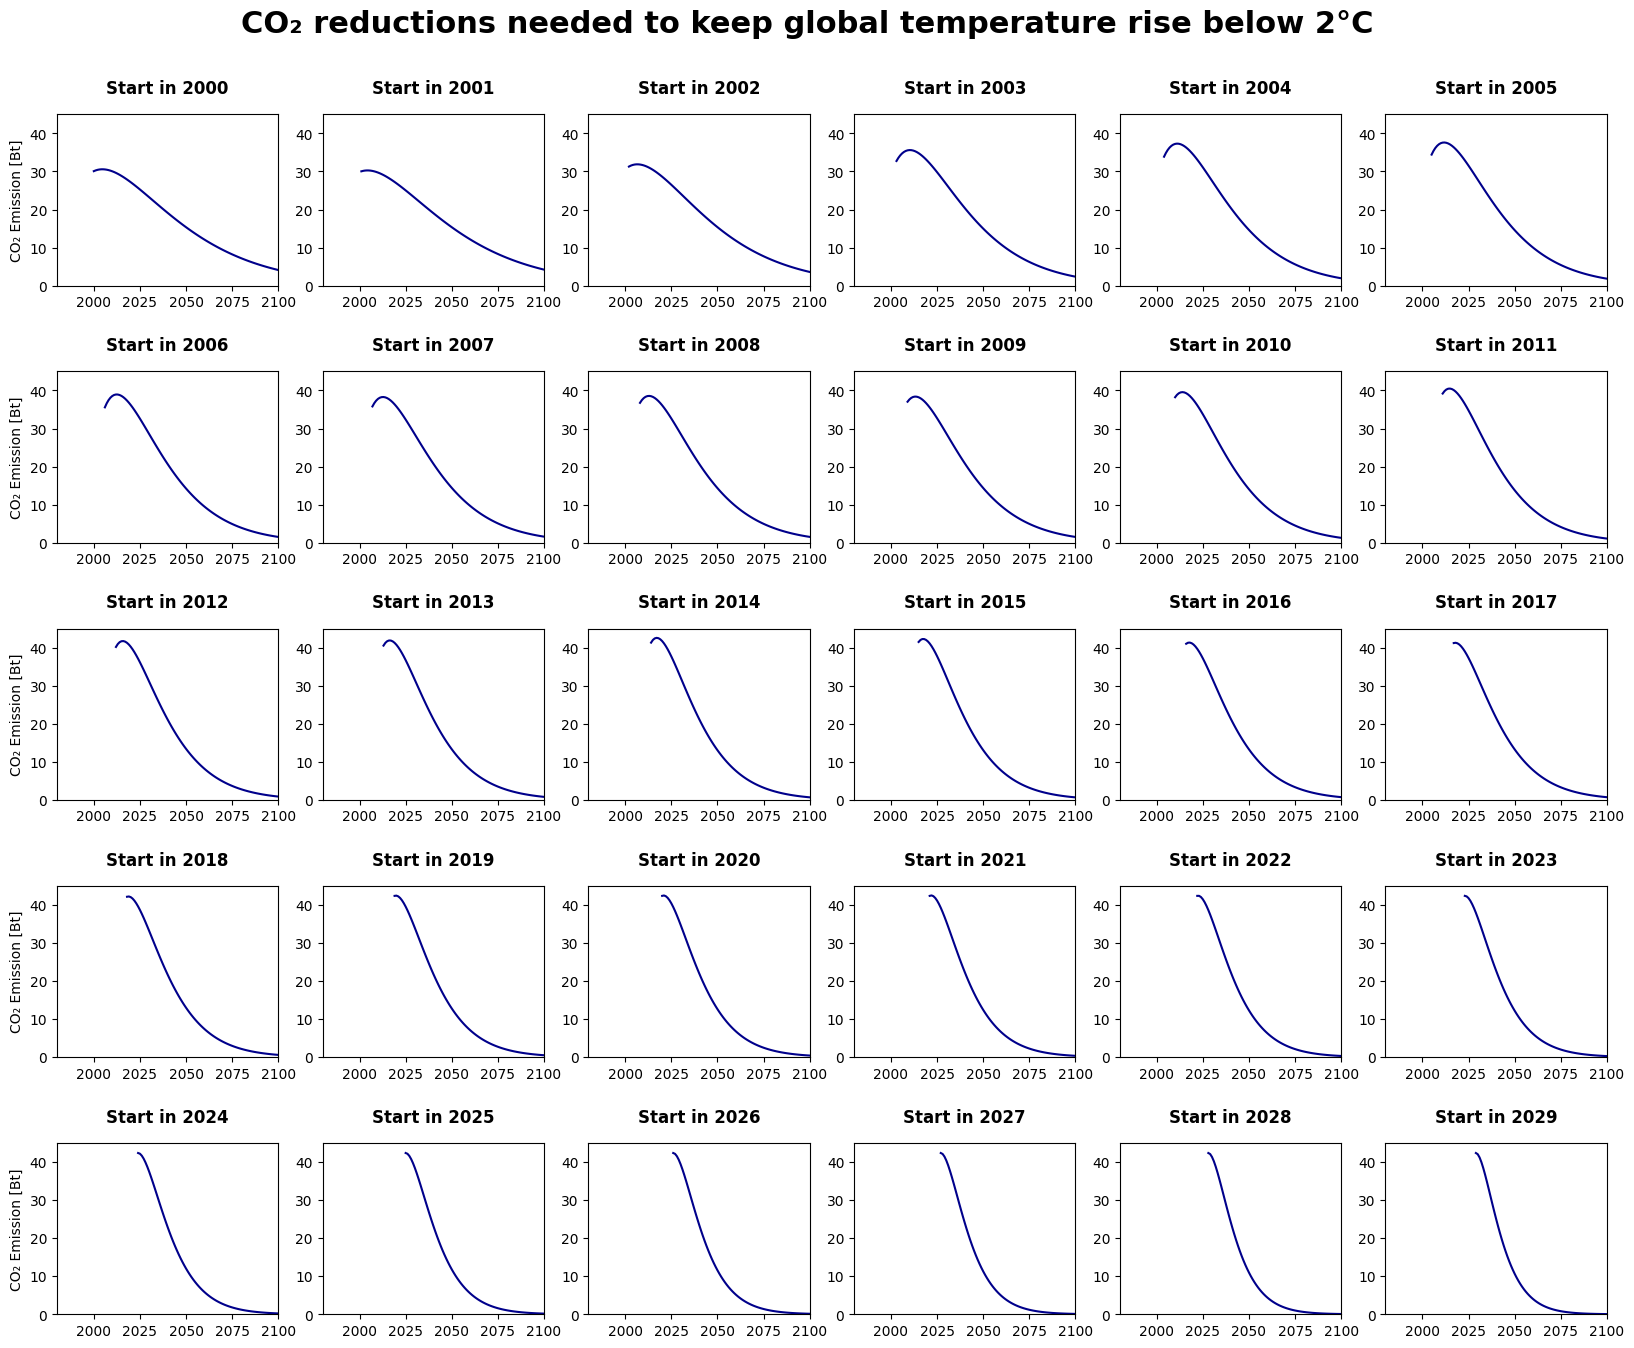

In [47]:
# Get list of unique entities
unique_entities = mitigation_filtered['Entity'].unique()[1:]

# Setting the figure size and subplot layout
fig, axes = plt.subplots(5, 6, figsize=(20, 15))

# Plotting the lines for each curve
for i, entity in enumerate(unique_entities):
    ax = axes[i // 6, i % 6]  # Use integer division and modulo operator to get the correct subplot

    # Filter the data for the current entity
    entity_data = mitigation_filtered[mitigation_filtered['Entity'] == entity]

    # Plotting the line for the entity
    sns.lineplot(data=entity_data, x='Year', y='CO2 mitigation curves to meet a 2C target', color="darkblue", ax=ax)

    # Setting the x-axis and y-axis ranges for each subplot
    ax.set_xlim(1980, 2100)
    ax.set_ylim(0, 45)

    # Setting the title and labels for each subplot
    ax.set_title(f'{entity}', pad=15, fontweight='bold')  # Add padding to the subplot title
    ax.set_xlabel('')  # Remove x-label
    ax.set_ylabel('CO₂ Emission [Bt]' if i % 6 == 0 else '')  # Show y-axis label only for the first column of subplots

# Adjusting the layout of subplots and reducing the spacing between the overall title and subplots
plt.subplots_adjust(hspace=0.5, top=0.91)

# Adding an overall title to the figure
fig.suptitle('CO₂ reductions needed to keep global temperature rise below 2°C', fontsize=22, fontweight='bold')
plt.show()

- The longer we delay the emission mitigation, the more drastic these reductions would need to be.

## 4. Greenhouse gas emissions by economic sectors

In [ ]:
# Filter out 'Country_name' == 'World'
sectors_filtered = sectors[sectors['Country_name'] != 'World']

# Group the data by year and calculate the total emissions for each sector
yearly_emissions = sectors_filtered.groupby('Year').sum()

# Get the list of sectors
sectors_list = yearly_emissions.columns[1:]

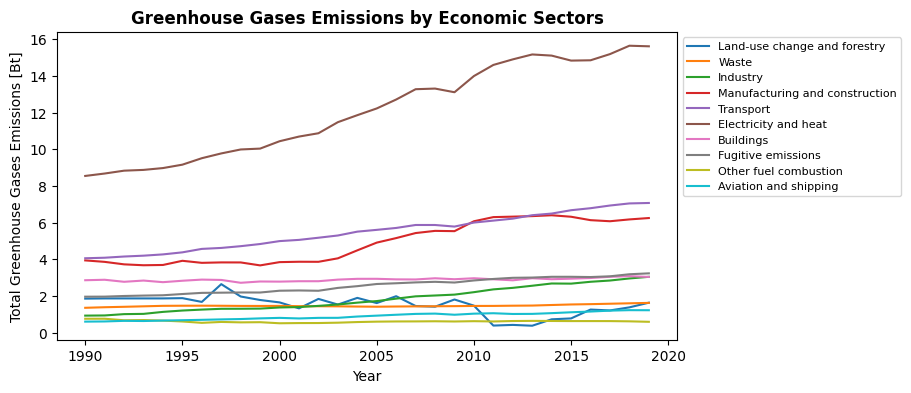

In [63]:
# Line chart for yearly emissions by sector
plt.figure(figsize=(8, 4))

for sector in sectors_list:
    plt.plot(yearly_emissions.index, yearly_emissions[sector] / 1e9, label=sector)

plt.xlabel('Year')
plt.ylabel('Total Greenhouse Gases Emissions [Bt]')
plt.title('Greenhouse Gases Emissions by Economic Sectors', fontweight='bold')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.show()


- Here we see that electricity and heat production are the largest contributor to global emissions. This is followed by transport, manufacturing and construction (largely cement and similar materials), and agriculture.
- We can also see that on a pie chart.

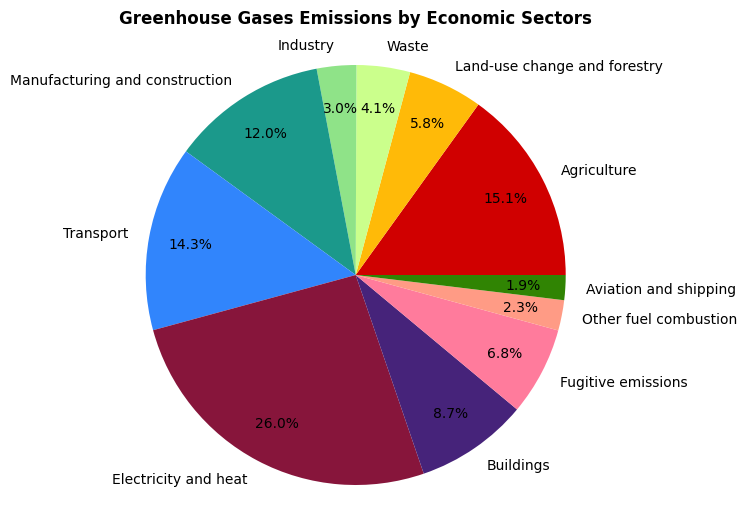

In [49]:
# Filter the data for 'Country_name' == 'World'
world_emissions = sectors[sectors['Country_name'] == 'World']

# Remove the 'Country_name' column
world_emissions = world_emissions.drop(columns='Country_name')

# Calculate the total emissions for each sector
sector_totals = world_emissions.iloc[0, 1:].tolist()

# Get the sector names
sector_names = world_emissions.columns[1:]

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sector_totals, labels=sector_names, autopct='%1.1f%%', pctdistance=0.8,
        colors=["#D00000", "#FFBA08", "#CBFF8C", "#8FE388", "#1B998B", "#3185FC", "#87153B", "#46237A", "#FF7B9C", "#FF9B85", "#308403"])
plt.title('Greenhouse Gases Emissions by Economic Sectors', fontweight='bold', pad=15)
plt.axis('equal')
plt.show()


- Let's check the percentages by different countries: ['United States', 'China', 'Russia', 'India', 'Brazil', 'Indonesia', 'Germany', 'Japan', 'Canada', 'United Kingdom'] --> top 10 countries on emissions

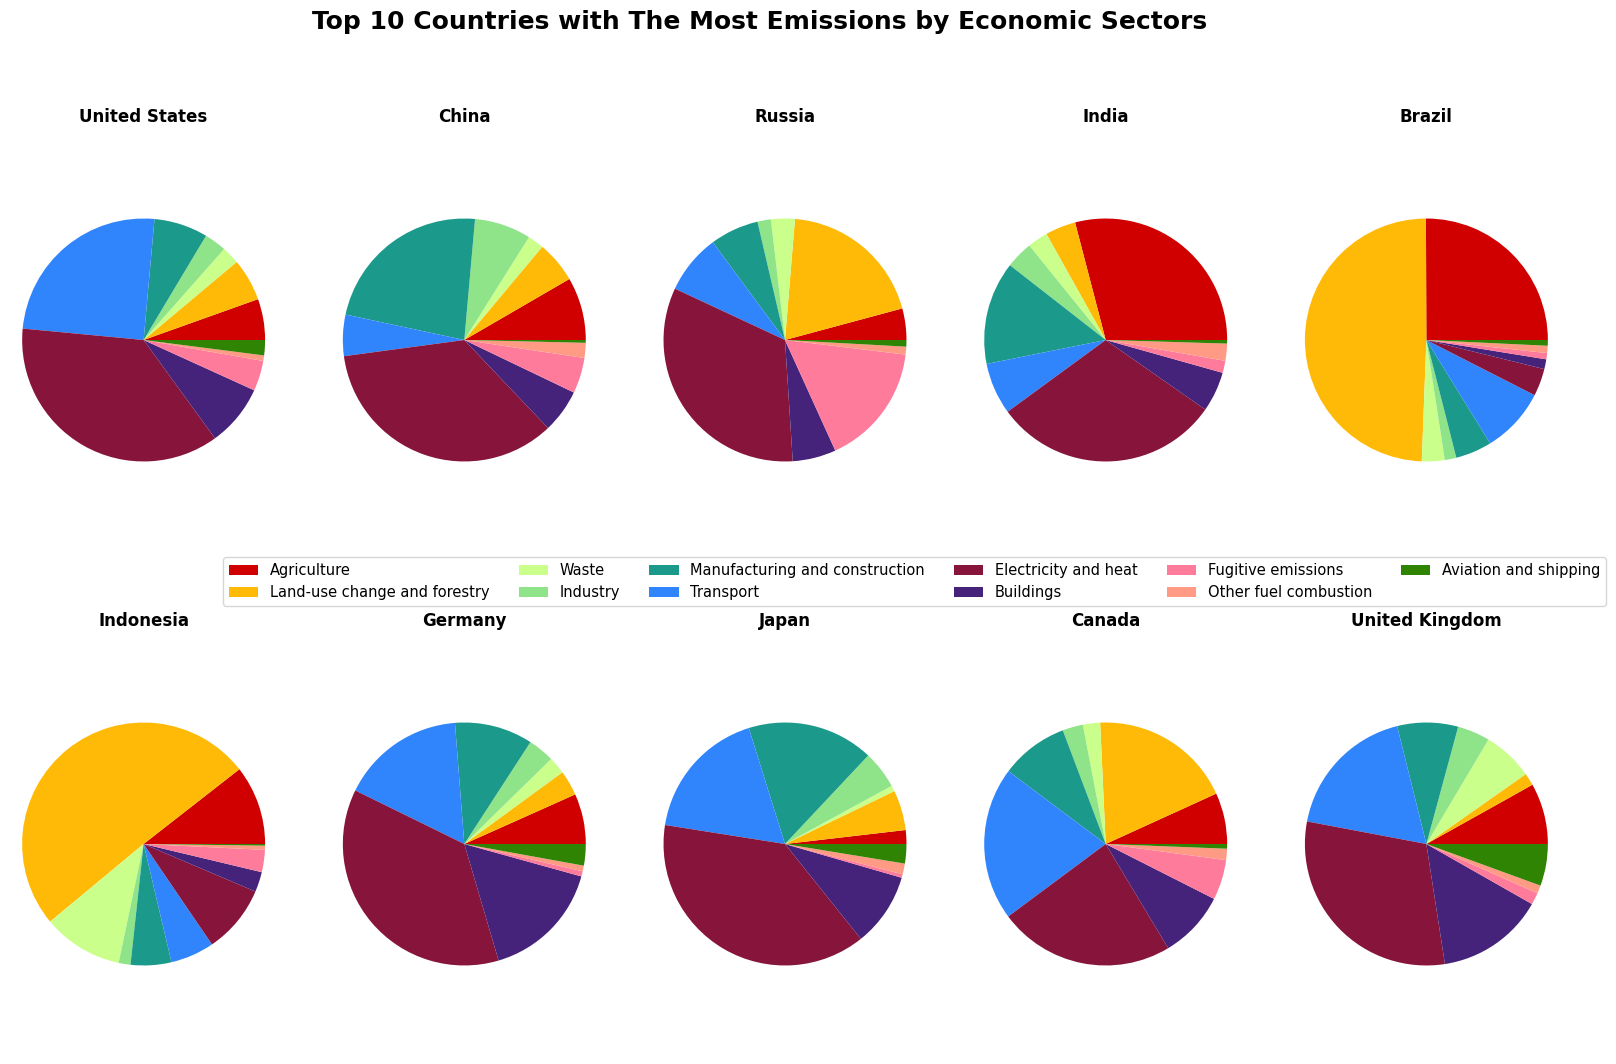

In [50]:
# Filter the data for the top 10 countries
top10_by_sector = sectors[sectors['Country_name'].isin(total_top_countries)]

# Get the sector names
sector_names = top10_by_sector.columns[2:]

# Create subplots with larger figure size
fig, axes = plt.subplots(2, 5, figsize=(20, 12))

# Plot pie chart for each country
for i, country in enumerate(total_top_countries):
    ax = axes[i // 5, i % 5]
    sector_totals = top10_by_sector[top10_by_sector['Country_name'] == country].iloc[:, 2:].sum().abs().tolist()
    ax.pie(sector_totals, labels=sector_names, textprops={'fontsize': 1, 'color':'white'},
           colors=["#D00000", "#FFBA08", "#CBFF8C", "#8FE388", "#1B998B", "#3185FC", "#87153B", "#46237A", "#FF7B9C", "#FF9B85", "#308403"])
    ax.set_title(country, fontweight='bold')
    ax.axis('equal')

plt.legend(ncol=6, bbox_to_anchor=(1.2, 1.2), fontsize=10.5)
plt.suptitle('Top 10 Countries with The Most Emissions by Economic Sectors', fontsize=18, fontweight='bold')
plt.show()


# PREPARE FOR TABLEAU DASHBOARD

In [51]:
# # Mount to Google Sheets
# from google.colab import auth
# auth.authenticate_user()

# # Import neccessary libraries
# import gspread
# from gspread_dataframe import set_with_dataframe
# from google.auth import default
# creds, _ = default()

# # Authorize Google Sheets API
# gc = gspread.authorize(creds)

- Prepare 3 tables for Tableau dashboard: emissions, temperature change and by sectors

In [52]:
# Reshape the DataFrame to long form
e_df = pd.melt(merged_data,
                    id_vars=['Country_name', 'Year'],
                    value_vars=['CO2_emission', 'CH4_emission', 'N2O_emission','Total_emission'],
                    var_name='Type_of_Emission',
                    value_name='Emission_Value')
e_df.head()

# For temperature
temp_df = merged_data[['Country_name', 'Year','Temperature_change']]
temp_df.head()

# Reshape the DataFrame to long form
s_df = pd.melt(sectors,
                    id_vars=['Country_name', 'Year'],
                    var_name='Sector',
                    value_name='Emission_Value')
s_df.head()

,Country_name,Year,Sector,Emission_Value
0,Afghanistan,1990,Agriculture,8.070000e+06
1,Afghanistan,1991,Agriculture,8.400000e+06
2,Afghanistan,1992,Agriculture,8.410000e+06
3,Afghanistan,1993,Agriculture,8.490000e+06
4,Afghanistan,1994,Agriculture,8.520000e+06


In [53]:
# # Create a new Google Spreadsheets
# sh = gc.create('GHGs_emission')

# def export_data_to_new_sheet(gsheet_key, worksheet_name, data):
#     """gsheet_key (str): ID of Google Sheet File. (Key is the part behind /d/ and before /edit
#                    For example: https://docs.google.com/spreadsheets/d/1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA/edit?usp=sharing
#                    Key is 1WISuNUrWc-7BPO2s-pD3P3qqqgiLh0wRpvTNNtN21gA
#        worksheet_id (int): 0, 1, 2, ...
#        data (DataFrame): data to write
#     """
#     sh = gc.open_by_key(gsheet_key)

#     # To create a new worksheet with 1000 rows and 26 columns
#     worksheet = sh.add_worksheet(worksheet_name, 1000, 26)
#     set_with_dataframe(worksheet, data)

In [54]:
# # Notice! Replace the key by your google sheet key
# export_data_to_new_sheet('1miqB7O0uc_HEQ8QmNe68S3J-ULFe4nhZz_sisymqWFg', "GHGs_emission", e_df)
# export_data_to_new_sheet('1miqB7O0uc_HEQ8QmNe68S3J-ULFe4nhZz_sisymqWFg', 'temperature_change', temp_df)
# export_data_to_new_sheet('1miqB7O0uc_HEQ8QmNe68S3J-ULFe4nhZz_sisymqWFg', "by_sectors", s_df)